## Solution: Image segmentation using flows

### Reading the image and defining a selection

The subsequent code is copied from the exercise notebook to make this solution notebook run independently.

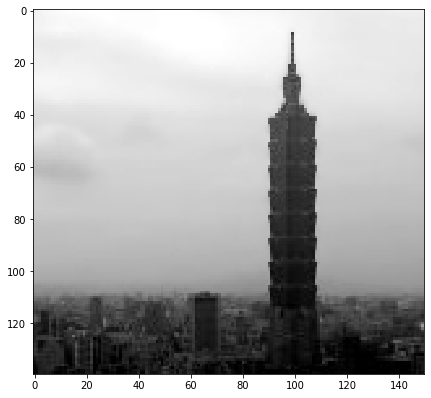

In [2]:
import imageSegmentation_module as helpers

# reading image and displaying it
img = helpers.read_image("07_imageSegmentation_picture.jpeg")
helpers.plot_image(img)

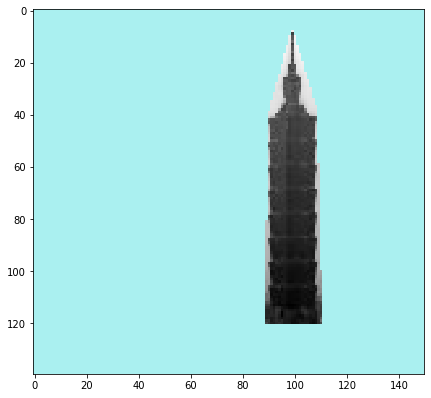

In [3]:
# Defining selection and displaying it
xy = [(89,120), (90,40), (99, 8), (108,38), (110,120)]
sel = helpers.polygonal_selection(xy, img.shape)
helpers.plot_selection(img, sel)

### Implementation

<font color='blue'><b>First task:</b></font> `get_digraph` function. It is already equipped with a parameter `a` that is relevant for the fourth task - setting $a=1$ (the default value), you get what corresponds to the actual first task.

In [4]:
def get_digraph(img, sel, x, a = 1):
    
    ## Your code goes here.
    
    import networkx as nx
    from math import pow
    
    def capacity(p, q):
        return pow(255 - abs(img[p[0]][p[1]] - img[q[0]][q[1]]), a)
    
    (m,n) = img.shape
    
    # define digraph
    G = nx.DiGraph()
    
    # add vertices
    for i in range(m):
        for j in range(n):
            G.add_node((i,j))
    s = "s"
    t = "t"
    G.add_node(s)
    G.add_node(t)
    
    # add edges
    for i in range(m):
        for j in range(n):
            if i < m-1:
                G.add_edge((i,j), (i+1,j), capacity = capacity((i,j), (i+1,j)))
                G.add_edge((i+1,j), (i,j), capacity = capacity((i+1,j), (i,j)))
            if j < n-1:
                G.add_edge((i,j), (i,j+1), capacity = capacity((i,j), (i,j+1)))
                G.add_edge((i,j+1), (i,j), capacity = capacity((i,j+1), (i,j)))
            if sel[i][j] == 1:
                G.add_edge("s", (i,j), capacity = x)
            if sel[i][j] == 0:
                G.add_edge((i,j), "t", capacity = x)
    
    return (G, s, t)

<font color='blue'><b>Second task:</b></font> Function `image_segmentation`. As above, the extra parameter $a$ (see task 4) is included already.

In [5]:
def image_segmentation(img, sel, x, a = 1):
    
    import networkx as nx
    
    # construct digraph
    (G, s, t) = get_digraph(img, sel, x, a)
    
    # calculate min cut
    (value, partition) = nx.minimum_cut(G, s, t)
    cut = partition[0] if s in partition[0] else partition[1]
    
    seg = sel * 0
    for v in cut:
        if v != s:
            seg[v[0]][v[1]] = 1
    
    return seg

<font color='blue'><b>Third task:</b></font> Testing. See the comments below.

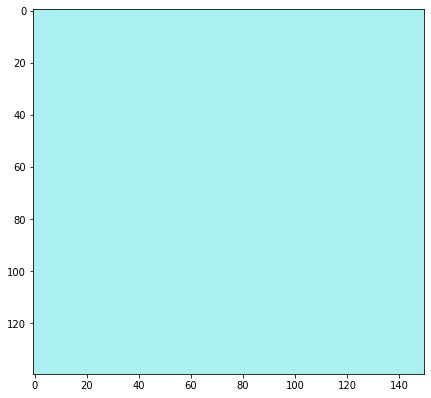

In [6]:
# testing

seg = image_segmentation(img, sel, 20)
helpers.plot_selection(img, seg)

For too small values of the parameter $x$, e.g. $x=20$ above, deviations from the preselection are not punished much at all compared to the penalties obtained for cutting pixels, so the minimum cut will be $\{s\}$, coresponding to an empty selection.

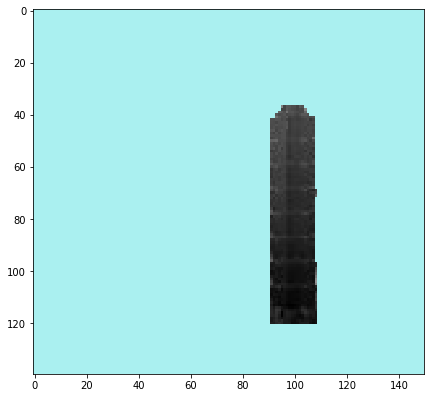

In [7]:
seg = image_segmentation(img, sel, 30)
helpers.plot_selection(img, seg)

For slightly larger values of the parameter $x$, e.g $x=30$ above, it is no longer beneficial to not keep any pixels of the preselection. Note that as in our picture, the skyscraper's color is dark gray while the background is light gray (and not 100% black/white), hence even cutting between skyscraper and background pixels will contribute something to the cut value. From this point of view, it is desirable that the segmented picture has a short boundary (a short boundary implies fewer cuts between neighbouring pixels), while still keeping most of the preselection. 

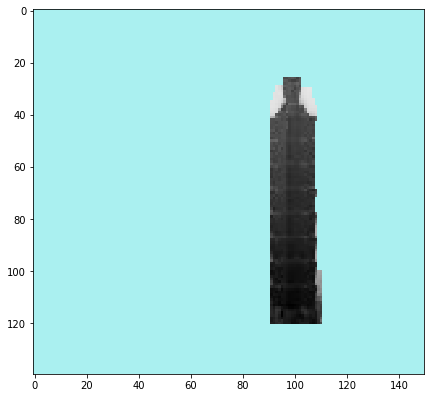

In [8]:
seg = image_segmentation(img, sel, 45)
helpers.plot_selection(img, seg)

Increasing $x$ to $x=45$, which makes keeping parts of the preselection more beneficial, we see that indeed, larger parts of the preselection are kept. Still, though, the effect described above (having short boundary while keeping preselection) leads to a bad result: At the top narrow part of the skyscraper, some obvious background pixels of the preselection are now kept, while the antenna remains cut off. The straight cut on the left side of the skyscraper is there for the same reason: Selecting the toothed shape of the Taipei 101 tower would keep more of the preselection, but at the same time create a longer boundary, with the latter creating more costs than the first can create benefit.

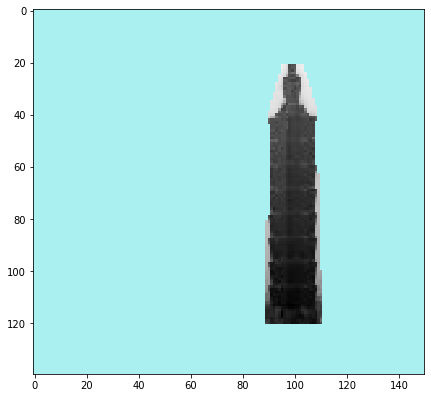

In [9]:
seg = image_segmentation(img, sel, 60)
helpers.plot_selection(img, seg)

Further increasing to $x=60$, the phenomenon described above, we see that more and more pixels of the preselection are kept - unfortunately, also more of the background pixels that we'd wish to cut.

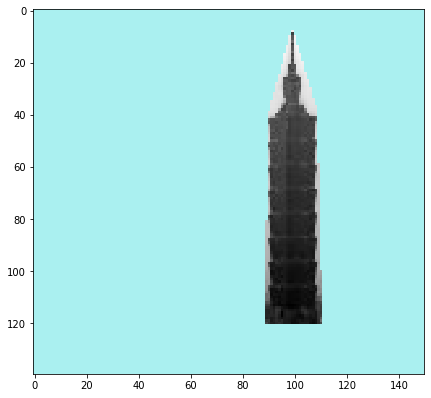

In [10]:
seg = image_segmentation(img, sel, 1000)
helpers.plot_selection(img, seg)

Very large values of $x$, e.g. $x=1000$ above, lead to an overproportional value of the preselection, with color differences playing a no role any longer, thus the preselection is returned.


The main problem of our approach is the capacity function that depends linarly on the difference of the grayscale values. We'd like to punish cuts between similar pixels overproportionally more compared to cuts between different pixels, i.e., we'd like the capacity function $u(p,q)$ to be convex in $|g_p-g_q|$. This is what the capacity function $u(p,q) := (255- |g_p-g_q|)^a$ proposed in task four does for $a>1$.

<font color='blue'><b>Fourth task:</b></font> The implementation above already takes the new parameter $a$ into account. The examples below show how results change with increasing $a$, and it shows some good choices of parameters.

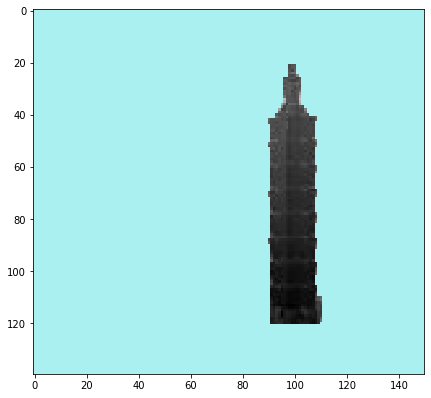

In [11]:
# testing

from math import pow
seg = image_segmentation(img, sel, pow(113,2), 2)
helpers.plot_selection(img, seg)

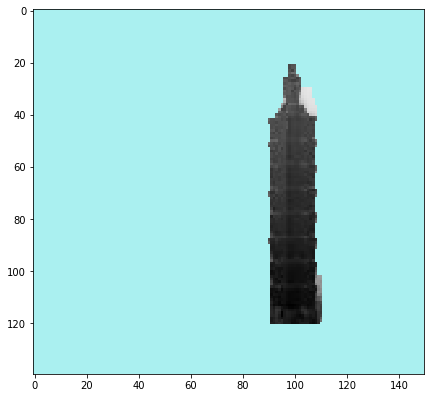

In [12]:
seg = image_segmentation(img, sel, pow(115,2), 2)
helpers.plot_selection(img, seg)

For $a=2$, we the results are better, but we still see effects similar to the ones with $a=1$: Parts of the tower are cut at $x=113^2$, but increasing $x$ to $x=115^2$ does mainly add backgroun

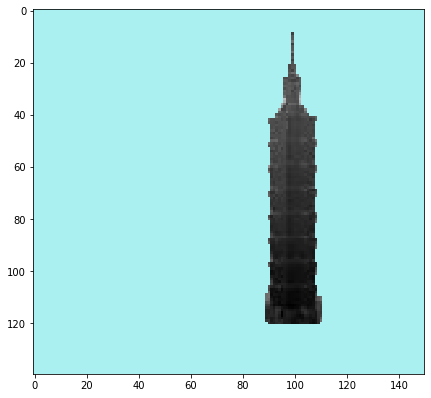

In [13]:
seg = image_segmentation(img, sel, pow(158,3), 3)
helpers.plot_selection(img, seg)

With $a=3$ and $x=158^3$, we are able to well capture the toothed structure of the skyscraper and the antenna on top, with some room for improvement at the narrow section of the towers top.

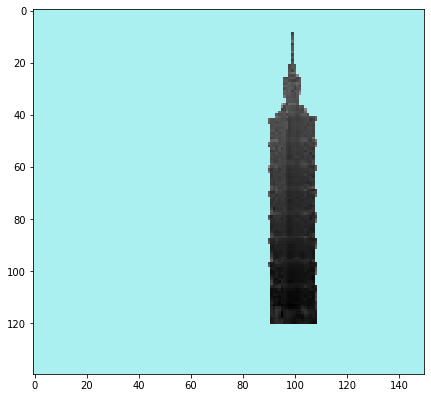

In [14]:
seg = image_segmentation(img, sel, pow(170,5), 5)
helpers.plot_selection(img, seg)

Going up to $a=5$ and choosing $x=170^5$ gives a good result at the tower's top, as well.